In [69]:
from scipy.stats import multivariate_normal
import itertools

import random
from typing import Callable, Mapping, NamedTuple, Tuple, Sequence
from functools import partial

import jax # Autograd package
import jax.numpy as jnp # GPU NumPy :)

import numpy as np

from collections import deque # Cyclic list with max capacity



# The class which defines the graph, transitions, and solver

## Below this cell is an experimentation section. Go to the last cell to run the experiment.

In [70]:
# example of adjacency matrix for 3 variables: x1, x2, x3



adj_matrices = {
    
    # A1 describes a graph where the edges are x1 -> x2 -> x3 
    "A1" : [[0,0,0],
            [1,0,0],
            [0,1,0]],

    # A2 describes a graph where the edges are x2 -> x1 -> x3 
    "A2" : [[0,1,0],
            [0,0,0],
            [1,0,0]],

    # A3 : x3,x2 -> x1
    "A3" : [[0,1,1],
            [0,0,0],
            [0,0,0]],

    # A4 : x2, x1, x3 (independent)
    "A4": [[0,0,0],
            [0,0,0],
            [0,0,0]],


    # A5 : x1 -> x2, x1,x2 -> x3
    "A5" : [[0,0,0],
            [1,0,0],
            [1,1,0]],

    # A6 : x2,x1 -> x3
    "A6" : [[0,0,0],
            [0,0,0],
            [1,1,0]]

    # AC describes a fully connected, undirected graph (not causal)
#     "AC": [[0,1,1],
#             [1,0,1],
#             [1,1,0]]
}

## You can either generate a graph randomly, or select from a small subset for a pre-defined Markov equivalence class

In [71]:
def generate_dataset(n,d,p,sigma):
    """
        n: number of samples per node
        k: number of nodes
        p: prob. of edge
        sigma: noise term for gaussian
    """
    draw_ints = ((-2,-0.5),(0.5,2))
    # graph of d nodes, n samples each
    X = np.zeros((n,d))
    B = X.copy()
    for i in range(n):
        for j in range(i+1,d):
            if np.random.choice((0,1),size=1,p=((1-p),p)):
                I1 = np.random.uniform(draw_ints[0][0],draw_ints[0][1],1)[0]
                I2 = np.random.uniform(draw_ints[1][0],draw_ints[1][1],1)[0]
                X[i,j] = np.random.choice((I1,I2),size=1,p=[.5,.5]) + np.random.normal(loc=0,scale=sigma,size=1)
                B[i,j] = 1
    y = X.T
    return y, X, B


In [72]:
def select_dataset(N,true_g,sigma):
    
    if true_g == "A1":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x2 + np.random.normal(loc=0,scale=sigma,size=N)
        
    elif true_g == "A2":
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x1 = x2 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
      
    elif true_g == "A3":
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x3 = np.random.normal(loc=0,scale=sigma,size=N)        
        x1 = x2 + x3 + np.random.normal(loc=0,scale=sigma,size=N)
    
    elif true_g == "A4":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x3 = np.random.normal(loc=0,scale=sigma,size=N)
        
    elif true_g == "A5":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = x1 + np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x1 + x2 + np.random.normal(loc=0,scale=sigma,size=N)

    elif true_g == "A6":
        x1 = np.random.normal(loc=0,scale=sigma,size=N)
        x2 = np.random.normal(loc=0,scale=sigma,size=N)
        x3 = x1 + x2 + np.random.normal(loc=0,scale=sigma,size=N)
    else:
        print(f"Graph {true_g} not found.")
        
    x = np.c_[x1,x2,x3]
    y = x.T
    return x,y

In [102]:
import numpy.ma as ma

def sample_interv_dist(n_samples, interv_node, coeff_matrix):
    # sample from the interventional distribution of a true graph
    # for simplicity, assume only one node is intervened on
    n_nodes = coeff_matrix.shape[1]
    X = np.full((n_samples, n_nodes), np.inf)
    # want to do this in such a way that nodes are assigned values in the right order
    # assign interventional node first
    X[:, interv_node] = np.random.normal(loc = 0, scale = 1, size = n_samples) # just random interventions for now; could actually fix concrete values later
    # dumb thing that might actually work
    # keep redoing matrix multiplications until there are no nan entries
    assigned_nodes = np.full(n_nodes, False) # keep track of which nodes have been assigned
    assigned_nodes[interv_node] = True
    while np.sum(assigned_nodes) < n_nodes:
        for node in range(n_nodes):   
            if node == interv_node:
                continue
            # if coeff matrix is just zero, assign noise and move on
            # print(coeff_matrix[:, node], node, X)
            if (coeff_matrix[:, node] == 0).all():
                X[:, node] = np.random.normal(loc = 0, scale = 1, size = n_samples)
            else:
                # use coeffs to mask the matrix
                coeff_mask = coeff_matrix[:, node] != 0
                X_masked = X[:, coeff_mask]
                coeff_masked = coeff_matrix[:, node][coeff_mask]
                res = X_masked @ coeff_masked + np.random.normal(loc = 0, scale = 1, size = n_samples)
                if np.sum(np.isnan(res)) != 0 or np.sum(np.isinf(res)) != 0:
                    continue
                else:
                    X[:, node] = res
            assigned_nodes[node] = 1
        # print(X)
    return X, X.T

# test it
interv_node = 1
coeff_matrix = np.array([[0, 1, 1], [0, 0, 2], [0, 0, 0]])
X, y = sample_interv_dist(5, interv_node, coeff_matrix)
print(X, y)

[[-1.56077457 -0.98348373 -2.68882686]
 [-3.69428529 -1.11709506 -7.00973323]
 [ 0.23926286 -0.02781485 -1.14986126]
 [ 1.62427859  0.74367194  2.71657929]
 [ 0.10785625 -0.03492988  0.21443962]] [[-1.56077457 -3.69428529  0.23926286  1.62427859  0.10785625]
 [-0.98348373 -1.11709506 -0.02781485  0.74367194 -0.03492988]
 [-2.68882686 -7.00973323 -1.14986126  2.71657929  0.21443962]]


In [ ]:
def log_lik(beta, y, x):

    mu = beta.dot(x.T)
    neg_llik = -1*norm(loc=mu, scale=1).logpdf(y).sum()

    return neg_llik

## Defining the MDP

In [ ]:
# code to check for cycles in an adjacency matrix
def exist_cycles(A):
    # NOTE: very slow at the moment
    n_nodes = A.shape[1]
    prod = A
    for _ in range(1, n_nodes):
        prod = np.matmul(prod, A)
        if np.sum(np.diag(prod)) != 0:
            # print(A)
            return True
    return False

In [152]:
from scipy.special import softmax
from scipy import optimize
from scipy.stats import norm

# Gym-like wrapper
class LabeledMDP():
    def __init__(self, true_graph, true_coeffs, generate_data=True, max_time = 200, check_cycles = True):
        if generate_data:
            self.true_graph=true_graph
            self.n_nodes = self.true_graph.shape[0]
            self.true_coeffs = true_coeffs
        
        else: # grab from adjacency
            self.true_graph = np.asarray(adj_matrices[true_graph])
            self.true_graph_name = true_graph
            self.n_nodes = np.asarray(self.true_graph).shape[0] #TODO: should not be shape 0 but 1
            self.true_coeffs = true_coeffs

        self.max_time = max_time
        self.generate_data=generate_data
        self.check_cycles = check_cycles


        # state space
        self.curr_graph = self.get_reset_graph()
        self.t = 0 # keep track of the timestep
        self.n_experiments = 0 # experiments run so far
        self.intervened_nodes = {} # keep track of which nodes have been intervened on
        self.obs_dim = np.prod(self.curr_graph.shape) + 2

        # action space
        # for each node, there are experiments with three different choices n: {10, 100, 1000}
        self.experiment_sizes = [5,20]
        self.experiment_actions = np.array(list(itertools.product(np.arange(self.n_nodes), self.experiment_sizes)))
        self.n_actions = len(self.experiment_actions)+1 # add one for the stop action

    def get_reset_graph(self):
        return np.zeros((self.n_nodes, self.n_nodes)) # the totally connected graph

    def reset(self):
        self.t = 0
        self.curr_graph = self.get_reset_graph()
        self.intervened_nodes = {}
        self.n_experiments = 0
        return self.create_state()

    def create_state(self):
        frac = len(self.intervened_nodes.keys()) / self.n_nodes
        s = np.concatenate((np.array(self.curr_graph).flatten(), [self.n_experiments, frac]))
        assert s.ndim == 1, "Not 1D feature vector"
        return s
    
    def correct_edges_frac(self):
        # compare correct and incorrect edges
        # use for shaped reward if desired
        n_correct_edges = np.sum(self.curr_graph == self.true_graph)
        # print(n_correct_edges, self.curr_graph == self.true_graph)
        if self.curr_graph is None:
          print(self.curr_graph)
        return n_correct_edges / np.prod(self.curr_graph.shape)

    def transition_graph(self, node, n_samples):
            # option: define candidate graphs the agent considers
            # for now, just set it to be all possible graphs
            # candidate_graphs = list(adj_matrices.keys())
            #print(f"This is a node {node}")
            # another option: generate random graphs based on which nodes you intervene on
            n_candidates = 2
            n_edges_to_flip = min(1, self.n_nodes - 1) # make sure you aren't flipping more edges than are possible
            # given the current graph, permute edges that are connected to the current node
            # rows are oncoming edges, so the intervened node is the column
            candidate_graphs = []
            n_candidates_generated = 0
            print("INSIDE TRANSITION F")
            while n_candidates_generated < n_candidates:
                G = np.copy(self.curr_graph)

                # pick another vertex randomly
                nodes_choice = np.delete(np.arange(self.n_nodes), node)
                nodes = np.random.choice(nodes_choice, size = n_edges_to_flip, replace = False)

                # print("pre")
                # print(G)
                for w in nodes:
                    if G[w, node] == G[node, w]: 
                        # since there are no cycles, this means the case where there are no edges
                        # randomly pick an edge
                        if np.random.random() < 1/2:
                            G[w, node] = 1
                        else:
                            G[node, w] = 1
                    else:
                        # there is an edge already, so either remove it or flip it
                        if np.random.random() < 1/2:
                            G[w, node] = 0
                            G[node, w] = 0
                        else:
                            temp = G[w, node]
                            G[w, node] = G[node, w]
                            G[node, w] = temp
                # print("post")
                # print(G)

                # # pick edges to randomly flip
                # edges = np.random.choice(self.n_nodes, size = n_edges_to_flip, replace = False)
                
                # # for each edge, give possibilities
                # for edge in edges:
                #     # print(edge, node)
                #     possible_choices = [-1, 1, 0]
                #     possible_choices.remove(G[edge, node])
                #     G[edge, node] = np.random.choice(possible_choices)
        
                # check for cycles
                print(G)
                if self.check_cycles and exist_cycles(G):
                    #print("cycles")
                    continue
                else:
                    #print("no cycles")
                    candidate_graphs.append(G)
                    n_candidates_generated += 1
            # also append the current graph
            candidate_graphs.append(self.curr_graph)


            # std dev of generated data
            sigma = 1.

            # placeholder
            # x,Y = generate_dataset(n_samples,self.true_graph_name,sigma)

            # interventional data
            x, Y = sample_interv_dist(n_samples, node, self.true_coeffs)
            # print(x, Y)

            ll=[]
            bic_scores = []
            # for g_name in candidate_graphs:
            for G in candidate_graphs:
                # G = np.array(adj_matrices[g_name])
                #print(f"This is a candidate graph {G}")
                graph_ll=0
                for var in range(self.n_nodes):
                    data = Y[var]
                    predictors = np.einsum('ij,ij->ij',np.tile(G[var],(n_samples,1)),x)
                    opt_res = optimize.minimize(fun = log_lik, 
                                            x0 = [0, 0, 0], 
                                            args = (data, predictors))

                    if opt_res['success'] == False:
                        print(f"Failed fit for model: {g_name} (true:{true_graph})")
                        graph_ll += -1e10
                              
                    graph_ll += -1*opt_res['fun']
                ll.append(graph_ll)
                graph_complexity = G.sum()
                
                # Note: scipy minimize returns the negative log likelihood value
                bic_score = graph_ll - .5 * np.log(n_samples) * graph_complexity
                bic_scores.append(bic_score)

            # transition to graphs w/ probability proportional to BIC scores
            # option 1: softmax
            p = softmax(bic_scores)
            # print(p)
            next_ix = np.random.choice(len(candidate_graphs), p = p)
            print(f"__Returned by transition function__: {np.array(candidate_graphs[next_ix])}")
            return np.array(candidate_graphs[next_ix])


    def step(self, a):
        assert a >= 0, "action out of range"
        assert a < self.n_actions, "action out of range"
        done = False
        r = 0
        info = 0 # the unshaped reward
        print(f"Action: {a}")
        if a == self.n_actions - 1:
            # STOP action
            done = True
            if (self.true_graph == self.curr_graph).all():
                r += 1
                info = 1
                print(f"Solved! {self.true_graph}")
        else:
            # experiment action
            node, n_samples = self.experiment_actions[a]
            self.n_experiments += n_samples #TODO: changed from += to = 
                                            # otherwise the state space is n_exp+=n_samples ...
            print(f"Going in function: {self.curr_graph}")
            self.curr_graph = self.transition_graph(node, n_samples)
            print(f"Outside of function: {self.curr_graph}")
            # compute loss inside agent to make it 
            r += self.correct_edges_frac() # shaped reward based on number of correct edges
            r -= n_samples / (10 * np.max(self.experiment_sizes))# penalty for size of experiment
        
        self.t += 1
#         if self.t >= self.max_time:
#             done = True
        return self.create_state(), r, done, info


In [147]:
# sanity checks for MDP defined above
labeled_mdp = LabeledMDP("A1",true_coeffs=np.asarray(adj_matrices["A1"]),generate_data=False)
s = labeled_mdp.reset()
print(s)

sp, r, done, _ = labeled_mdp.step(1)
print(sp, r, done)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Action: 1
Going in function: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
INSIDE TRANSITION F
__Returned by transition function__: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Outside of function: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  0.] 0.6777777777777778 False


## Defining a RL agent

In [148]:
# Types for declaring the neural networks functions simplier and
# more intuitive
ActivationFn = Callable[[np.ndarray], np.ndarray]
Parameters = Mapping[str, np.ndarray]
InitFn = Callable[[np.ndarray], Parameters]
ForwardFn = Callable[[Parameters, np.ndarray], np.ndarray]
Layer = Tuple[InitFn, ForwardFn]


# Simple optimizer that applies the following formula to update the parameters:
# param' = param - learning_rate * grad
def sgd(params: Sequence[Parameters], 
        gradients: Sequence[Parameters],
        learning_rate: float) -> Sequence[Parameters]:
    new_parameters = []
    for i in range(len(params)):
        zipped_grads = zip(params[i].items(), gradients[i].items())
        new_parameters.append({
            k: v - dv * learning_rate for (k, v), (_, dv) in zipped_grads})

    return new_parameters 

    # Create a linear layer 
def linear(in_features: int, 
           out_features: int, 
           activation: ActivationFn = lambda x: x) -> Layer:

    def init_fn(random_key: jnp.ndarray) -> Parameters:
        W_key, b_key = jax.random.split(random_key)

        x_init = jax.nn.initializers.xavier_uniform() 
        norm_init = jax.nn.initializers.normal()

        W = x_init(W_key, shape=(out_features, in_features))
        bias = norm_init(b_key, shape=())
        return dict(W=W, bias=bias)

    def forward_fn(params: Parameters, x: jnp.ndarray) -> jnp.ndarray:
        W = params['W']
        bias = params['bias']
        return activation(jnp.dot(W, x) + bias)

    return init_fn, forward_fn

# Creates a sequential model that simply reduces the input over a sequence
# of layers
def sequential(*layers: Sequence[Layer]):
    init_fns, forward_fns = zip(*layers)

    def init_fn(random_key: np.ndarray):
        layer_keys = jax.random.split(random_key, num=len(layers))
        return [init_fn(k) for init_fn, k in zip(init_fns, layer_keys)]

    def forward_fn(params: Sequence[Parameters], x: np.ndarray) -> np.ndarray:
        for fn, p in zip(forward_fns, params):
            x = fn(p, x)
        return x

    return init_fn, forward_fn

In [149]:
# base agent
class BaseAgent():
    def __init__(self, env_params, agent_params, names_to_suppress=[]):
        self.env_params = env_params
        self.agent_params = agent_params 
        self.names_to_suppress = names_to_suppress
        self.name = self.generate_name()
        self.train_set_list=[]
        self.test_set_list=[]

        # RL stuff
        self.gamma = self.agent_params["gamma"]
        self.Q = np.zeros([env_params["n_actions"], env_params["obs_dim"]])

        if "eps" in self.agent_params:
            self.eps = self.agent_params["eps"]

    def set_env(self, env):
        self.env = env

    def generate_name(self):
        # generate agent full name from agent_params and base_name 
        params = ["{}={}".format(name, self.agent_params[name]) for name in self.agent_params if name not in self.names_to_suppress]
        return "{}_{}".format(self.base_name, '_'.join(params))

    def act(self, s):
        pass 

    def eps_greedy_act(self, s):
        if self.eval is False:
            eps = self.eps
        else:
            # act greedily if we're evaluating
            eps = 0

        if np.random.random() < eps:
            action = np.random.randint(self.env_params["n_actions"])
        else: 
            Qs = self.Q @ s
            assert np.isnan(Qs).sum() == 0
            action = np.random.choice(np.where(Qs == Qs.max())[0])
        return action
  
    # def get_eps(self):
    #     eps = self.eps_init * (1. - self.frame / self.eps_zero_by) + (self.eps_final) * self.frame / self.eps_zero_by
    #     eps = max(min(eps, self.eps_init), self.eps_final)
    #     return eps

    def step(self, s, a, r, sp, done):
        pass
    
    def run(self):
        pass

        
# linear Q-learning
class QL(BaseAgent):
    def __init__(self, *args, **kwargs):
        self.base_name = "QL"
        super().__init__(*args, **kwargs)

    def act(self, s):
        return self.eps_greedy_act(s)

    def step(self, s, a, r, sp, done):
        self.Q[a, :] += self.agent_params["lr"] * (r + self.agent_params["gamma"] * (1. - done) * np.max(self.Q @ sp) - (self.Q @ s)[a]) * s

    def run(self,env,eval=False):
        # for stats 
        self.returns = []
        self.unshaped_returns = []
        self.returns_and_frame_count = []
        self.frame = 0
        self.tracker = []
        self.eval=eval

        # run it
        for episode in range(self.env_params["episodes"]):
            s = env.reset()
            G = 0
            unshaped_G = 0
            done = False
            self.curr_frame_count = 0
            while done is not True:
                a = self.act(s)      
                sp, r, done, unshaped_r = env.step(a)
                self.tracker.append((a,s,env.true_graph,r))                
                
                if (sp[:env.n_nodes**2].reshape(-1,env.n_nodes)== env.true_graph).all() and eval is False:
                    self.step(s,env.n_actions-1,100,sp,True)
                    G+=1
                else:
                    #G += (self.gamma ** self.curr_frame_count) * r # if we want to use the discounted return as the eval metric
                    #unshaped_G += (self.gamma ** self.curr_frame_count) * unshaped_r
                    G += r # if we want to use total reward as the eval metric

                # update agent if we're not evaluating
                if eval is False:
                    self.step(s, a, r, sp, done)

                self.curr_frame_count += 1
                if self.curr_frame_count >= self.env_params["max_frames_per_ep"]:
                    # NOTE: THIS NEEDS TO BE AFTER self.step() SO THAT WE BOOTSTRAP CORRECTLY
                    done = True

                # update state
                s = sp

                self.frame += 1    

            self.returns.append(G/self.curr_frame_count) 
            self.returns_and_frame_count.append([G/self.curr_frame_count, self.curr_frame_count])
            
            # print("ep = {} | frame = {} | G = {} | ep length = {}".format(episode, self.frame - 1, unshaped_G, self.curr_frame_count))

# Transition class, could be useful   
# A transition or a experience is a "recorded" interaction of the agent
# with the environment. A Transition contains:
#  - state: An observation of the environment
#  - next_state: The environment observation after taking an action
#  - action: The decision took by the agent at the transition timestep
#  - reward: The reported benefit of taking the specified action
#  - is_terminal: Whether or not the observation is a "game over"
class Transition(NamedTuple):
    state: np.ndarray
    next_state: np.ndarray
    action: int
    reward: int
    is_terminal: bool


# DQL
class DQL(BaseAgent):
    def __init__(self, *args, **kwargs):
        self.base_name = "DQL"
        super().__init__(*args, **kwargs)
        
    def initialize(self, env):
        self.env = env
        
        key = jax.random.PRNGKey(0)
        
        # Create the deep QNetwork
        self.dqn_init_fn, self.dqn_forward_fn = sequential(
            linear(self.env.obs_dim, 64, jax.nn.relu),
            linear(64, 32, jax.nn.relu),
            linear(32, self.env.n_actions)) # out size is the predicted graph

        self.key, subkey = jax.random.split(key)
        self.dqn_parameters = self.dqn_init_fn(subkey)

        # Vectorize the model to work with batches
        self.dqn_forward_fn = jax.vmap(self.dqn_forward_fn, in_axes=(None, 0))

        # We create a copy of parameters to compute the target QValues 
        self.target_parameters = self.dqn_parameters
        
        # We compile the function with jit to improve performance
        self.backward_fn = jax.jit(jax.grad(self.compute_loss))

        # Declare an SGD optimizer
        self.optimizer = partial(sgd, learning_rate=self.agent_params["lr"])
        self.optimizer = jax.jit(self.optimizer)


    #@jax.grad # Differentiate the loss with respect to the model weights
    def compute_loss(self,parameters, x, y, actions):
        # Mean squared error as loss function
        mse = lambda y1, y2: (y1 - y2) ** 2
        # Get the q values corresponding to specified actions
        q_values = self.dqn_forward_fn(parameters, x)
        q_values = q_values[np.arange(x.shape[0]), actions]
        return np.mean(mse(y, q_values))
        

    def act(self,s,key=0):
        key, sk = jax.random.split(key)
        # We are using an epsilon greedy policy for exploration
        # Meaning that at every timestep we flip a biased coin with EPSILON 
        # probability of being true and 1- EPSILON of being false. In case it is true
        # we take a random action
        if jax.random.uniform(sk, shape=(1,)) < EPSILON:
            # Remember that we have only 2 actions (left, right)
            action = jax.random.randint(sk, shape=(1,), minval=0, maxval=2)
        else:
            s = np.expand_dims(s, axis=0)
            q_values = self.dqn_forward_fn(self.dqn_parameters, s)[0]
            # Pick the action that maximizes the value
            action = np.argmax(q_values)

        return int(action)
    
             
    def run(self,env,eval=False):
        self.returns = []
        self.unshaped_returns = []
        self.returns_and_frame_count = []
        self.frame = 0
        
        def train():
            if len(memory) < self.env_params["batch_size"]:
                return self.dqn_parameters # No train because we do not have enough experiences

            # Experience replay
            transitions = random.sample(memory, k=self.env_params["batch_size"])

            # Convert transition into tensors. Converting list of tuples to
            # tuple of lists
            transitions = Transition(*zip(*transitions))
            states = np.array(transitions.state)
            next_states = np.array(transitions.next_state)
            actions = np.array(transitions.action)
            rewards = np.array(transitions.reward)
            is_terminal = np.array(transitions.is_terminal)

            # Compute the next Q values using the target parameters
            # We vectorize the model using vmap to work with batches
            self.Q = self.dqn_forward_fn(self.target_parameters, next_states)
            # Bellman equation
            yj = rewards + self.agent_params["gamma"] * np.max(self.Q, axis=-1)
            # In case of terminal state we set a 0 reward
            yj = np.where(is_terminal, 0, yj)

            # Compute the Qvalues corresponding to the sampled transitions
            # and backpropagate the mse loss gradients
            gradients = self.backward_fn(self.dqn_parameters, states, yj, actions)

            # Update the deep q network parameters using our optimizer
            return self.optimizer(self.dqn_parameters, gradients)
      
     
        for episode in range(self.env_params["episodes"]):

            state = env.reset()
            G = 0
            unshaped_G = 0
            done = False
            curr_frame_count = 0    
   
            if eval:
                self.agent_params["eps"] = 0 # No more random actions    

            while done is not True:
                for timestep in range(self.env_params["max_frames_per_ep"]):

                    if done: 
                        print(f"Solved!: {done}")
                        break # The pole has felt, we should start a new episode

                    # Take an action
                    # With jax is mandatory to provide a random key at any random operation
                    key, subkey = jax.random.split(self.key)
                    action = agent.act(state,subkey)
                    next_state, reward, done, unshaped_r = env.step(action)

                    G += (agent.agent_params["gamma"] ** curr_frame_count) * reward # if we want to use the discounted return as the eval metric
                    unshaped_G += (agent.agent_params["gamma"] ** curr_frame_count) * unshaped_r

                    if not eval: # train
                        
                        # Generate a transition
                        t = Transition(state=state, next_state=next_state, 
                                       reward=reward, is_terminal=done,
                                       action=action)

                        memory.append(t) # Store the transition 

                        self.dqn_parameters = train() # Update the agent with experience replay

                    curr_frame_count += 1
                    if curr_frame_count >= self.env_params["max_frames_per_ep"]:
                        # NOTE: THIS NEEDS TO BE AFTER self.step() SO THAT WE BOOTSTRAP CORRECTLY
                        #print(f"Failed to solve after {curr_frame_count} tries.")
                        done = True

                    # Every timestep we reduce the probability of taking random actions
                    # this is because we want to explotate what we have learn during the 
                    # previous episodes
                    self.agent_params["eps"] -= 2e-5


                    self.returns.append(reward) 
                    self.returns_and_frame_count.append([reward, curr_frame_count])  

                    state = next_state
               # if episode % 20 == 0:
                  #  if not eval: 
                       # print(f'__Train__ Episode[{episode}]: Reward: {reward}, Unshapped reward: {unshaped_G}')
                
                # At the end of the episode we update the target parameters
                self.target_parameters = self.dqn_parameters



## Run QL or DQL

In [153]:
MAX_TRAINING_EPOCHS=100
MAX_EPISODES = 1 # Number of max episodes to train the agent
MAX_EPISODE_STEPS = 10
BATCH_SIZE = 64 # Number of instances used to train at every timestep with experience replay
GAMMA = .99 # Discount factor for future rewards
EPSILON = .1 # Noise to perform epsilon greedy exploration
LEARNING_RATE =1e-3
training_set = ["A1", "A2", "A3", "A6"]
test_set = ["A4", "A5"]
train_set_list = []
test_set_list = []

env = LabeledMDP("A1",true_coeffs=np.asarray(adj_matrices["A1"]),generate_data=False)
obs_dim = env.obs_dim
n_actions = env.n_actions
key = jax.random.PRNGKey(0)


# hyperparameters
#H = 5
#gamma = 1 - 1 / H

agent_params = {"lr": LEARNING_RATE, "eps": EPSILON, "gamma": GAMMA}

env_params = {"batch_size": BATCH_SIZE,
              "episodes": MAX_EPISODES, 
              "max_frames_per_ep": MAX_EPISODE_STEPS, 
              "n_actions": n_actions, 
              "obs_dim": obs_dim,
             "input": training_set}


# Could use moving average for result reporting
#ma = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w

# agent
#agent = DQL(env_params, agent_params)


# initialize DQL using env parameters (must comment out if using QL)
#agent.initialize(env)
#memory = deque(maxlen=int(1e3))


def single_training_run(seed=0):
    # set seed
    np.random.seed(seed)
    agent = QL(env_params, agent_params)
    agent.set_env(adj_matrices["A1"])
    # results
    results = []
    # train the agent
    for _ in range(MAX_TRAINING_EPOCHS):
        if _ % 2 == 0:
            print(f"training epoch = {_ + 1} / {MAX_TRAINING_EPOCHS}")

        # sample randomly from the training set
        train = training_set[np.random.choice(len(training_set))]
        train_set_list.append(train)

        # train
        env = LabeledMDP(train,true_coeffs=np.asarray(adj_matrices[train]),generate_data=False)
        agent.run(env,eval=False)
        exp_actions = agent.tracker.copy()  
#        print(exp_actions)
        train_res = agent.returns[0]

        # test the agent
        test_returns = []
        for test in test_set:
            test_set_list.append(test)
            env = LabeledMDP(test,true_coeffs=np.asarray(adj_matrices[test]),generate_data=False)
            agent.run(env, eval = True)
            test_returns.append(agent.returns)
        test_res = np.mean(test_returns)
        print(f"Avg train Return = {train_res}")
        print(f"Avg test Return = {test_res}")
        results.append((train_res,test_res,exp_actions))

#    train_res = np.array(train_res).squeeze()
 #   test_res = np.array(test_res).squeeze()
    return results


In [154]:
def multiple_runs(N):
    train_res = []
    test_res = []    
    train_experiment_actions = []
    for n in range(N):
        results = single_training_run(n)
        tr_r=[]
        tt_r=[]
        for r in results:            
            train_experiment_actions.append(r[2])
            tr_r.append(r[0])
            tt_r.append(r[1])
        train_res.append(tr_r)
        test_res.append(tt_r)
    
    train_res = np.array(train_res)
    test_res = np.array(test_res)

    return train_res, test_res, train_experiment_actions
      
    
N = 1
train_res, test_res, train_experiment_actions = multiple_runs(N)

Streaming output truncated to the last 5000 lines.
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
__Returned by transition function__: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Outside of function: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Action: 5
Going in function: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
INSIDE TRANSITION F
[[0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
__Returned by transition function__: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Outside of function: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
Action: 5
Going in function: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]
INSIDE TRANSITION F
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]]
__Returned by transition function__: [[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
Outside of function: [[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
Action: 5
Going in function: [[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
INSIDE TRANSITION F
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 1. 0.]]
__Returned by transitio

In [ ]:
n_nodes=3
K = n_nodes**2
n_actions = agent.env_params['n_actions'] 
experiment_actions = np.array(list(itertools.product(np.arange(n_nodes), [5,20])))

density=[]
score=[]
for i,tmp in enumerate(train_experiment_actions):
    if i % MAX_TRAINING_EPOCHS == 0:
        print(f"New run, new seed.")
    print("Begin experiment...")
    for tstep in range(len(tmp)):
        action, state, true_graph, reward = tmp[tstep]
        graph = state[:K].reshape(-1,n_nodes)
        score.append(reward)
        n_exp = state[-2]
        density.append(n_exp)
        frac = state[-1]
        if action == n_actions -1:
            print(f"Graph observed: \n{graph}, Experiment status: Solved = {(graph==true_graph).all()},\n Action taken: Stopped.,\n True Graph: \n{true_graph}")
        else:
            print(f"Graph observed: \n{graph},  Experiment status: Solved = {(graph==true_graph).all()}, \nAction taken: intervene on node: {experiment_actions[action-1][0]} with a sample of {experiment_actions[action-1][1]},\n  True Graph: \n{true_graph}")
    print("Experiment over.")

NameError: ignored

array([[ 1.        , -0.07594528],
       [-0.07594528,  1.        ]])

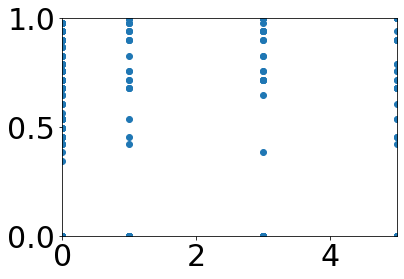

In [ ]:
plt.scatter(density,score)
np.corrcoef(density,score)
#print(density,score)

## Plot the data from the RL experiments

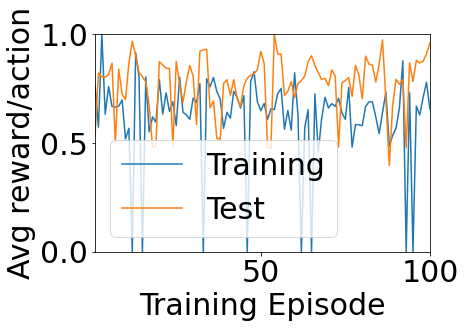

In [158]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
matplotlib.rcParams.update({'font.size': 30})

figsize = (15, 10)

# normalize
train_res /= np.max(train_res)
test_res /= np.max(test_res)

# plot the training and test curves, cumulative avg
plt.plot(np.arange(len(train_res[0])) + 1, train_res[0] , label = "Training")
plt.plot(np.arange(len(train_res[0])) + 1, test_res[0], label = "Test")
plt.xlabel("Training Episode")
plt.ylabel("Avg reward/action")
plt.legend()
plt.show()

In [ ]:
ook

In [ ]:
train_res

array([1.])

In [ ]:
def plot_action_graph(train_experiment_actions):
    # mapping to action taken 
    experiment_actions = np.array(list(itertools.product(np.arange(n_nodes), )))
    
    